In [1]:
import torch
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm

print("Libraries imported successfully")


Libraries imported successfully


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.64 GB


In [3]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
Number of GPUs: 1


In [4]:
import os

# Use home directory (no sudo needed)
MOUNT_POINT = os.path.expanduser("~/anu_try/HOPEFULLY_FINAL/gcs-bucket")
os.makedirs(MOUNT_POINT, exist_ok=True)
print(f"✅ Created mount point: {MOUNT_POINT}")

✅ Created mount point: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket


In [5]:
import subprocess

BUCKET_NAME = "argonne-dataset"

# Mount command
mount_cmd = f"gcsfuse --implicit-dirs {BUCKET_NAME} {MOUNT_POINT}"
result = subprocess.run(mount_cmd, shell=True, capture_output=True, text=True)

if result.returncode == 0:
    print(f"✅ Successfully mounted gs://{BUCKET_NAME}")
    print(f"   Access at: {MOUNT_POINT}")
else:
    print(f"❌ Mount failed:")
    print(result.stderr)
    print(result.stdout)

✅ Successfully mounted gs://argonne-dataset
   Access at: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket


In [6]:
INPUT_PATH = f"{MOUNT_POINT}/2025_UChicago_Distance_Data/final_preprocessed"

if os.path.exists(INPUT_PATH):
    print(f"✅ Mount successful!")
    print(f"\n📁 Available folders in final_preprocessed:")
    folders = os.listdir(INPUT_PATH)
    for folder in sorted(folders):
        folder_path = os.path.join(INPUT_PATH, folder)
        if os.path.isdir(folder_path):
            try:
                files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
                print(f"   - {folder}: {len(files)} images")
            except Exception as e:
                print(f"   - {folder}: (error reading)")
else:
    print(f"❌ Mount point not found: {INPUT_PATH}")
    print(f"   Check if bucket and path exist")

✅ Mount successful!

📁 Available folders in final_preprocessed:
   - .ipynb_checkpoints: 0 images
   - DistDS-4_uic: 1024 images
   - DistDS-5_Nashville1: 2249 images
   - DistDS-5_Nashville2: 2310 images
   - DistDS-6_Nashville3: 2076 images
   - DistDS-7_Nashville4: 1989 images
   - DistDS01_Chattanooga_April06: 1083 images
   - LA1: 1708 images
   - LA2: 1358 images
   - Test: 2107 images
   - Train: 40286 images
   - Val: 3347 images


In [7]:
MOUNT_POINT = os.path.expanduser("~/anu_try/HOPEFULLY_FINAL/gcs-bucket")
GCS_DATA_DIR = f"{MOUNT_POINT}/lead_vehicle_features/preprocessed_datasets"
TRAIN_DATASET_PATH = f'{GCS_DATA_DIR}/train_dataset.pt'
VAL_DATASET_PATH = f'{GCS_DATA_DIR}/val_dataset.pt'
TEST_DATASET_PATH = f'{GCS_DATA_DIR}/test_dataset.pt'

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
import os

class MemoryEfficientDataset(Dataset):
    """
    Load preprocessed data WITHOUT loading everything into RAM
    Loads samples on-demand from disk
    """
    
    def __init__(self, dataset_file):
        print(f"📥 Initializing dataset: {dataset_file}")
        
        # Get file size
        size_gb = os.path.getsize(dataset_file) / (1024**3)
        print(f"   File size: {size_gb:.2f} GB")
        
        # Only load metadata, not actual data
        print(f"   Loading sample indices (not loading full data into RAM)...")
        
        # Load file but keep on disk, access on-demand
        self.dataset_file = dataset_file
        
        # Load just to get length
        samples = torch.load(dataset_file, map_location='cpu')
        self.length = len(samples)
        
        # Store sample indices
        print(f"   ✅ Found {self.length:,} samples")
        print(f"   💡 Data will be loaded on-demand (memory efficient)")
        
        # Save first sample structure for reference
        self.sample_structure = {k: v.shape for k, v in samples[0]['inputs'].items()}
        print(f"   📊 Sample structure:")
        for key, shape in self.sample_structure.items():
            print(f"      {key}: {shape}")
        
        # Keep reference to data
        self.samples = samples
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # Load sample on-demand
        sample = self.samples[idx]
        return sample['inputs'], sample['target']

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle

class MemoryEfficientDataset(Dataset):
    """
    Load preprocessed data WITHOUT loading everything into RAM
    Loads samples on-demand from disk - truly memory efficient
    """
    
    def __init__(self, dataset_file):
        print(f"📥 Initializing dataset: {dataset_file}")
        
        size_gb = os.path.getsize(dataset_file) / (1024**3)
        print(f"   File size: {size_gb:.2f} GB")
        
        print(f"   Loading metadata only (NOT loading full data)...")
        
        # Store file path - DON'T load into memory
        self.dataset_file = dataset_file
        
        # Load ONLY first sample to get structure and length
        print(f"   Reading first sample for metadata...")
        with open(dataset_file, 'rb') as f:
            # Load minimal metadata
            all_samples = torch.load(f, map_location='cpu')
            self.length = len(all_samples)
            self.sample_structure = {k: v.shape for k, v in all_samples[0]['inputs'].items()}
            del all_samples  # Delete immediately
        
        print(f"   ✅ Found {self.length:,} samples")
        print(f"   💡 Data loaded on-demand from disk (NOT in RAM)")
        
        print(f"   📊 Sample structure:")
        for key, shape in self.sample_structure.items():
            print(f"      {key}: {shape}")
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # Load ONLY this sample from disk when needed
        all_samples = torch.load(self.dataset_file, map_location='cpu')
        sample = all_samples[idx]
        return sample['inputs'], sample['target']


In [10]:
# Cell 6: Load datasets with memory-efficient settings
print("Loading datasets...")
print("=" * 70)

# Check file sizes first
import os

train_size_gb = os.path.getsize(TRAIN_DATASET_PATH) / (1024**3)
val_size_gb = os.path.getsize(VAL_DATASET_PATH) / (1024**3)
test_size_gb = os.path.getsize(TEST_DATASET_PATH) / (1024**3)

print(f"Dataset sizes:")
print(f"  Train: {train_size_gb:.2f} GB")
print(f"  Val: {val_size_gb:.2f} GB")
print(f"  Test: {test_size_gb:.2f} GB")

# Load datasets one at a time
train_dataset = MemoryEfficientDataset(TRAIN_DATASET_PATH)

# Don't load test dataset yet (only need train and val)
val_dataset = MemoryEfficientDataset(VAL_DATASET_PATH)

# Reduce batch size if train dataset is very large
if train_size_gb > 30:
    BATCH_SIZE = 32  # Reduce from 64
    print(f"\n⚠️  Large dataset detected. Reducing batch size to {BATCH_SIZE}")

# Create dataloaders with reduced workers and no pin_memory
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,  # Reduced from 4
    pin_memory=False,  # Disabled to save memory
    persistent_workers=False  # Disabled to save memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=False,
    persistent_workers=False
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {32}")
print(f"  Workers: 2 (reduced to save memory)")

Loading datasets...
Dataset sizes:
  Train: 23.16 GB
  Val: 2.01 GB
  Test: 1.26 GB
📥 Initializing dataset: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket/lead_vehicle_features/preprocessed_datasets/train_dataset.pt
   File size: 23.16 GB
   Loading sample indices (not loading full data into RAM)...
   ✅ Found 38,108 samples
   💡 Data will be loaded on-demand (memory efficient)
   📊 Sample structure:
      full_image: torch.Size([3, 224, 224])
      car_patch: torch.Size([3, 64, 64])
      geometric: torch.Size([10])
📥 Initializing dataset: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket/lead_vehicle_features/preprocessed_datasets/val_dataset.pt
   File size: 2.01 GB
   Loading sample indices (not loading full data into RAM)...
   ✅ Found 3,314 samples
   💡 Data will be loaded on-demand (memory efficient)
   📊 Sample structure:
      full_image: torch.Size([3, 224, 224])
      car_patch: torch.Size([3, 64, 64])
      geometric: torch.Size([10])

DataLoaders created:
  Train batches:

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [9]:
class HybridDistanceEstimator_EfficientNet(nn.Module):
    """
    3-branch hybrid model: EfficientNetB4 (full scene) + EfficientNetB3 (vehicle patch) + Geometric
    Enhanced with L2 regularization, BatchNorm, and deeper fusion head
    """
    
    def __init__(self, l2_strength=1e-4, dropout_rate=0.3):
        super(HybridDistanceEstimator_EfficientNet, self).__init__()
        
        self.l2_strength = l2_strength
        
        # ===== BRANCH 1: Full Image - EfficientNetB4 =====
        efficientnet_scene = models.efficientnet_b4(pretrained=True)
        
        # Remove classifier, keep backbone
        self.full_image_backbone = nn.Sequential(*list(efficientnet_scene.children())[:-1])
        
        # Freeze backbone
        for param in self.full_image_backbone.parameters():
            param.requires_grad = False
        
        # Full image head with regularization
        self.full_image_head = nn.Sequential(
            nn.Linear(1792, 512),  # EfficientNetB4 outputs 1792 features
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        )
        
        
        # ===== BRANCH 2: Car Patch - EfficientNetB3 =====
        efficientnet_patch = models.efficientnet_b3(pretrained=True)
        
        # Remove classifier, keep backbone
        self.car_patch_backbone = nn.Sequential(*list(efficientnet_patch.children())[:-1])
        
        # Freeze backbone
        for param in self.car_patch_backbone.parameters():
            param.requires_grad = False
        
        # Car patch head with regularization
        self.car_patch_head = nn.Sequential(
            nn.Linear(1536, 256),  # EfficientNetB3 outputs 1536 features
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        
        
        # ===== BRANCH 3: Geometric Features =====
        self.geometric_branch = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate * 0.8),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        
        # ===== FUSION HEAD - Enhanced with 4 layers =====
        # Input: 128 + 64 + 32 = 224 features
        self.fusion = nn.Sequential(
            nn.Linear(128 + 64 + 32, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate * 0.7),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize fusion head weights"""
        for module in self.fusion.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, full_image, car_patch, geometric):
        # Branch 1: Full image through EfficientNetB4
        full_features = self.full_image_backbone(full_image)
        full_features = full_features.view(full_features.size(0), -1)  # Flatten
        full_features = self.full_image_head(full_features)
        
        # Branch 2: Car patch through EfficientNetB3
        patch_features = self.car_patch_backbone(car_patch)
        patch_features = patch_features.view(patch_features.size(0), -1)  # Flatten
        patch_features = self.car_patch_head(patch_features)
        
        # Branch 3: Geometric features
        geo_features = self.geometric_branch(geometric)
        
        # Fusion: Concatenate all branches
        combined = torch.cat([full_features, patch_features, geo_features], dim=1)
        
        # Distance prediction
        output = self.fusion(combined)
        
        return output.squeeze(1)
    
    def get_l2_regularization(self):
        """Compute L2 regularization term"""
        l2_reg = 0
        for param in self.full_image_head.parameters():
            l2_reg += torch.norm(param)
        for param in self.car_patch_head.parameters():
            l2_reg += torch.norm(param)
        for param in self.geometric_branch.parameters():
            l2_reg += torch.norm(param)
        for param in self.fusion.parameters():
            l2_reg += torch.norm(param)
        return self.l2_strength * l2_reg
    
    def unfreeze_backbone_layers(self, num_layers_full=20, num_layers_patch=15):
        """Unfreeze top layers for fine-tuning"""
        # Unfreeze EfficientNetB4 layers
        backbone_full_layers = list(self.full_image_backbone.children())
        for layer in backbone_full_layers[-num_layers_full:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # Unfreeze EfficientNetB3 layers
        backbone_patch_layers = list(self.car_patch_backbone.children())
        for layer in backbone_patch_layers[-num_layers_patch:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        print(f"Unfroze {num_layers_full} layers in full_image_backbone")
        print(f"Unfroze {num_layers_patch} layers in car_patch_backbone")

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridDistanceEstimator_EfficientNet(l2_strength=1e-4, dropout_rate=0.3)
model = model.to(device)

print("✅ EfficientNet Hybrid Model Created")
print(f"\nArchitecture:")
print(f"   Branch 1 (Scene): EfficientNetB4 (1792 features)")
print(f"                     → 512 → 256 → 128 (with BatchNorm + Dropout)")
print(f"   Branch 2 (Vehicle): EfficientNetB3 (1536 features)")
print(f"                       → 256 → 128 → 64 (with BatchNorm + Dropout)")
print(f"   Branch 3 (Geometric): 10 → 64 → 32 → 32 (with BatchNorm)")
print(f"   Fusion Head: 224 → 256 → 128 → 64 → 32 → 1 (distance)")
print(f"\nDevice: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")


/home/jupyter/ashwin_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter/ashwin_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jupyter/ashwin_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `we

✅ EfficientNet Hybrid Model Created

Architecture:
   Branch 1 (Scene): EfficientNetB4 (1792 features)
                     → 512 → 256 → 128 (with BatchNorm + Dropout)
   Branch 2 (Vehicle): EfficientNetB3 (1536 features)
                       → 256 → 128 → 64 (with BatchNorm + Dropout)
   Branch 3 (Geometric): 10 → 64 → 32 → 32 (with BatchNorm)
   Fusion Head: 224 → 256 → 128 → 64 → 32 → 1 (distance)

Device: cuda

Total parameters: 29,870,257
Trainable parameters: 1,625,409
Trainable %: 5.44%


In [11]:
criterion = nn.HuberLoss(delta=1.0)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=8, 
    min_lr=1e-6
)

print("\n✅ Training setup complete")
print(f"   Loss: HuberLoss")
print(f"   Optimizer: Adam (lr=1e-3)")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=8)")


✅ Training setup complete
   Loss: HuberLoss
   Optimizer: Adam (lr=1e-3)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=8)


In [12]:
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

from torch.cuda.amp import autocast

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")
    for inputs, targets in pbar:
        full_image = inputs['full_image'].to(device)
        car_patch = inputs['car_patch'].to(device)
        geometric = inputs['geometric'].to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(full_image, car_patch, geometric)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
    
    return running_loss / num_batches


def validate(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    num_batches = 0
    all_predictions = []
    all_targets = []
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]  ")
    with torch.no_grad():
        for inputs, targets in pbar:
            full_image = inputs['full_image'].to(device)
            car_patch = inputs['car_patch'].to(device)
            geometric = inputs['geometric'].to(device)
            targets = targets.to(device)
            
            with autocast():
                outputs = model(full_image, car_patch, geometric)
                loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            num_batches += 1
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            del full_image, car_patch, geometric, targets, outputs, loss
            gc.collect()
    
    avg_loss = running_loss / num_batches
    predictions = np.array(all_predictions)
    targets_np = np.array(all_targets)
    mae = np.mean(np.abs(predictions - targets_np))
    rmse = np.sqrt(np.mean((predictions - targets_np)**2))
    
    torch.cuda.empty_cache()
    return avg_loss, mae, rmse

print("✅ Training functions ready (HuberLoss)")

✅ Training functions ready (HuberLoss)


In [13]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def unfreeze_backbones(model, optimizer, learning_rate, weight_decay=1e-4):
    """Unfreeze backbone networks for fine-tuning"""
    print("\n" + "="*70)
    print("UNFREEZING BACKBONES FOR FINE-TUNING")
    print("="*70)
    
    for param in model.full_image_backbone.parameters():
        param.requires_grad = True
    for param in model.car_patch_backbone.parameters():
        param.requires_grad = True
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Trainable parameters: {trainable_params:,}")
    
    optimizer = optim.Adam([
        {'params': model.full_image_backbone.parameters(), 'lr': learning_rate * 0.1},
        {'params': model.car_patch_backbone.parameters(), 'lr': learning_rate * 0.1},
        {'params': model.full_image_head.parameters(), 'lr': learning_rate},
        {'params': model.car_patch_head.parameters(), 'lr': learning_rate},
        {'params': model.geometric_branch.parameters(), 'lr': learning_rate},
        {'params': model.fusion.parameters(), 'lr': learning_rate},
    ], weight_decay=weight_decay)
    
    print(f"   Backbone LR: {learning_rate * 0.1:.6f} (10x lower)")
    print(f"   Head LR: {learning_rate:.6f}")
    print("="*70 + "\n")
    
    return optimizer


def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save(checkpoint, checkpoint_path)
    
    if is_best:
        best_path = os.path.join(checkpoint_dir, 'best_model.pt')
        torch.save(checkpoint, best_path)
        print(f"   💾 Saved best model!")
    
    return checkpoint_path

def train_full(model, train_loader, val_loader, optimizer, scheduler, scaler, 
               device, num_epochs, unfreeze_epoch, checkpoint_dir, learning_rate, 
               early_stopping_patience=15):
    """Full training loop with HuberLoss and Early Stopping"""
    
    criterion = nn.HuberLoss(delta=1.0)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_rmse': [],
        'lr': [],
        'unfrozen': []
    }
    
    best_val_loss = float('inf')
    backbones_unfrozen = False
    patience_counter = 0
    
    print("="*70)
    print("STARTING TRAINING (HuberLoss, Mixed Precision, Early Stopping)")
    print("="*70)
    
    for epoch in range(num_epochs):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*70}")
        
        if epoch == unfreeze_epoch and not backbones_unfrozen:
            optimizer = unfreeze_backbones(model, optimizer, learning_rate)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
            backbones_unfrozen = True
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch)
        val_loss, val_mae, val_rmse = validate(model, val_loader, criterion, device, epoch)
        scheduler.step(val_loss)
        
        if backbones_unfrozen:
            backbone_lr = optimizer.param_groups[0]['lr']
            head_lr = optimizer.param_groups[2]['lr']
            current_lr = head_lr
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['lr'].append(current_lr)
        history['unfrozen'].append(backbones_unfrozen)
        
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss (Huber): {train_loss:.4f}")
        print(f"   Val Loss (Huber):   {val_loss:.4f}")
        print(f"   Val MAE:            {val_mae:.4f} meters")
        print(f"   Val RMSE:           {val_rmse:.4f} meters")
        if backbones_unfrozen:
            print(f"   Backbone LR: {backbone_lr:.6f}")
            print(f"   Head LR:     {head_lr:.6f}")
        else:
            print(f"   LR:         {current_lr:.6f}")
        print(f"   Backbones:  {'Unfrozen' if backbones_unfrozen else 'Frozen'}")
        
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"   ✅ Best model! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏱️  No improvement. Patience: {patience_counter}/{early_stopping_patience}")
        
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir, is_best)
        
        if patience_counter >= early_stopping_patience:
            print(f"\n🛑 EARLY STOPPING! No improvement for {early_stopping_patience} epochs")
            break
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Backbones unfrozen at epoch {unfreeze_epoch+1}")
    print(f"Loss function: HuberLoss (delta=1.0)")
    
    return history


In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import gc

In [ ]:
scaler = GradScaler()
history = train_full(
     model, train_loader, val_loader,
    optimizer=optimizer,
     scheduler=scheduler,
     scaler=scaler,
     device=device,
     num_epochs=50,
     unfreeze_epoch=15,
     checkpoint_dir='./checkpointsv2',
     learning_rate=1e-3,
     early_stopping_patience=15
    
 )

print("✅ Ready to train with HuberLoss(delta=1.0)")

/var/tmp/ipykernel_9398/1597367328.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING (HuberLoss, Mixed Precision, Early Stopping)

Epoch 1/50


Epoch 1 [Train]:   0%|          | 0/1191 [00:00<?, ?it/s]/var/tmp/ipykernel_9398/66989842.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]  :   0%|          | 0/104 [00:00<?, ?it/s]/var/tmp/ipykernel_9398/66989842.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]  : 100%|██████████| 104/104 [01:08<00:00,  1.52it/s, loss=2.3252]



📊 Epoch 1 Summary:
   Train Loss (Huber): 4.1337
   Val Loss (Huber):   1.8419
   Val MAE:            2.2699 meters
   Val RMSE:           4.1041 meters
   LR:         0.001000
   Backbones:  Frozen
   ✅ Best model! (val_loss: 1.8419)
   💾 Saved best model!

Epoch 2/50


Epoch 2 [Val]  : 100%|██████████| 104/104 [01:02<00:00,  1.65it/s, loss=1.0650]



📊 Epoch 2 Summary:
   Train Loss (Huber): 1.9227
   Val Loss (Huber):   1.2258
   Val MAE:            1.6216 meters
   Val RMSE:           3.5646 meters
   LR:         0.001000
   Backbones:  Frozen
   ✅ Best model! (val_loss: 1.2258)
   💾 Saved best model!

Epoch 3/50


Epoch 3 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=1.9676]



📊 Epoch 3 Summary:
   Train Loss (Huber): 1.8421
   Val Loss (Huber):   1.3927
   Val MAE:            1.7950 meters
   Val RMSE:           3.6485 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 1/15

Epoch 4/50


Epoch 4 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=1.6712]



📊 Epoch 4 Summary:
   Train Loss (Huber): 1.8467
   Val Loss (Huber):   1.1881
   Val MAE:            1.5750 meters
   Val RMSE:           3.6617 meters
   LR:         0.001000
   Backbones:  Frozen
   ✅ Best model! (val_loss: 1.1881)
   💾 Saved best model!

Epoch 5/50


Epoch 5 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=1.8249]



📊 Epoch 5 Summary:
   Train Loss (Huber): 1.7877
   Val Loss (Huber):   1.2608
   Val MAE:            1.6549 meters
   Val RMSE:           3.4951 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 1/15

Epoch 6/50


Epoch 6 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.64it/s, loss=1.6871]



📊 Epoch 6 Summary:
   Train Loss (Huber): 1.7515
   Val Loss (Huber):   1.2765
   Val MAE:            1.6771 meters
   Val RMSE:           3.3962 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 2/15

Epoch 7/50


Epoch 7 [Val]  : 100%|██████████| 104/104 [01:02<00:00,  1.66it/s, loss=0.9351]



📊 Epoch 7 Summary:
   Train Loss (Huber): 1.7102
   Val Loss (Huber):   1.3413
   Val MAE:            1.7583 meters
   Val RMSE:           3.5583 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 3/15

Epoch 8/50


Epoch 8 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=1.1991]



📊 Epoch 8 Summary:
   Train Loss (Huber): 1.7184
   Val Loss (Huber):   1.1727
   Val MAE:            1.5750 meters
   Val RMSE:           3.3649 meters
   LR:         0.001000
   Backbones:  Frozen
   ✅ Best model! (val_loss: 1.1727)
   💾 Saved best model!

Epoch 9/50


Epoch 9 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.65it/s, loss=1.1577]



📊 Epoch 9 Summary:
   Train Loss (Huber): 1.7107
   Val Loss (Huber):   1.5140
   Val MAE:            1.9579 meters
   Val RMSE:           3.5430 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 1/15

Epoch 10/50


Epoch 10 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=2.3375]



📊 Epoch 10 Summary:
   Train Loss (Huber): 1.6916
   Val Loss (Huber):   1.4498
   Val MAE:            1.8609 meters
   Val RMSE:           3.4885 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 2/15

Epoch 11/50


Epoch 11 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.64it/s, loss=1.5004]



📊 Epoch 11 Summary:
   Train Loss (Huber): 1.6721
   Val Loss (Huber):   1.1857
   Val MAE:            1.5896 meters
   Val RMSE:           3.2242 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 3/15

Epoch 12/50


Epoch 12 [Val]  : 100%|██████████| 104/104 [01:02<00:00,  1.67it/s, loss=1.2921]



📊 Epoch 12 Summary:
   Train Loss (Huber): 1.6120
   Val Loss (Huber):   1.2441
   Val MAE:            1.6441 meters
   Val RMSE:           3.3752 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 4/15

Epoch 13/50


Epoch 13 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=1.7140]



📊 Epoch 13 Summary:
   Train Loss (Huber): 1.6141
   Val Loss (Huber):   1.1718
   Val MAE:            1.5645 meters
   Val RMSE:           3.3314 meters
   LR:         0.001000
   Backbones:  Frozen
   ✅ Best model! (val_loss: 1.1718)
   💾 Saved best model!

Epoch 14/50


Epoch 14 [Val]  : 100%|██████████| 104/104 [01:02<00:00,  1.66it/s, loss=1.3265]



📊 Epoch 14 Summary:
   Train Loss (Huber): 1.6126
   Val Loss (Huber):   1.1239
   Val MAE:            1.5067 meters
   Val RMSE:           3.1816 meters
   LR:         0.001000
   Backbones:  Frozen
   ✅ Best model! (val_loss: 1.1239)
   💾 Saved best model!

Epoch 15/50


Epoch 15 [Val]  : 100%|██████████| 104/104 [01:03<00:00,  1.63it/s, loss=1.7946]



📊 Epoch 15 Summary:
   Train Loss (Huber): 1.6215
   Val Loss (Huber):   1.3532
   Val MAE:            1.7740 meters
   Val RMSE:           3.4131 meters
   LR:         0.001000
   Backbones:  Frozen
   ⏱️  No improvement. Patience: 1/15

Epoch 16/50

UNFREEZING BACKBONES FOR FINE-TUNING
   Trainable parameters: 29,870,257
   Backbone LR: 0.000100 (10x lower)
   Head LR: 0.001000



Epoch 16 [Val]  : 100%|██████████| 104/104 [01:04<00:00,  1.62it/s, loss=1.7234]



📊 Epoch 16 Summary:
   Train Loss (Huber): 1.5785
   Val Loss (Huber):   1.2346
   Val MAE:            1.6374 meters
   Val RMSE:           3.2834 meters
   Backbone LR: 0.000100
   Head LR:     0.001000
   Backbones:  Unfrozen
   ⏱️  No improvement. Patience: 2/15

Epoch 17/50


Epoch 17 [Train]:  63%|██████▎   | 749/1191 [03:29<02:01,  3.62it/s, loss=3.3856]

## starting from 22

In [15]:
def load_checkpoint_resume(checkpoint_path, model, device):
    """Load checkpoint - don't load optimizer state"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    
    print("="*70)
    print(f"✅ Model loaded from epoch {checkpoint['epoch']}")
    print(f"   Train loss: {checkpoint['train_loss']:.4f}")
    print(f"   Val loss: {checkpoint['val_loss']:.4f}")
    print(f"   Resuming from epoch {start_epoch}")
    print("="*70)
    
    return model, start_epoch

def train_full_resume(model, train_loader, val_loader, optimizer, scheduler, scaler, 
                      device, num_epochs, start_epoch, unfreeze_epoch, checkpoint_dir, 
                      learning_rate, early_stopping_patience=15):
    """Resume training from checkpoint"""
    
    criterion = nn.HuberLoss(delta=1.0)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_rmse': [],
        'lr': [],
        'unfrozen': []
    }
    
    best_val_loss = float('inf')
    backbones_unfrozen = (start_epoch > unfreeze_epoch)
    patience_counter = 0
    
    print("="*70)
    print(f"RESUMING TRAINING FROM EPOCH {start_epoch} (HuberLoss)")
    print("="*70)
    
    for epoch in range(start_epoch, num_epochs):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*70}")
        
        if epoch == unfreeze_epoch and not backbones_unfrozen:
            optimizer = unfreeze_backbones(model, optimizer, learning_rate)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
            backbones_unfrozen = True
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch)
        val_loss, val_mae, val_rmse = validate(model, val_loader, criterion, device, epoch)
        scheduler.step(val_loss)
        
        if backbones_unfrozen:
            backbone_lr = optimizer.param_groups[0]['lr']
            head_lr = optimizer.param_groups[2]['lr']
            current_lr = head_lr
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['lr'].append(current_lr)
        history['unfrozen'].append(backbones_unfrozen)
        
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss (Huber): {train_loss:.4f}")
        print(f"   Val Loss (Huber):   {val_loss:.4f}")
        print(f"   Val MAE:            {val_mae:.4f} meters")
        print(f"   Val RMSE:           {val_rmse:.4f} meters")
        if backbones_unfrozen:
            print(f"   Backbone LR: {backbone_lr:.6f}")
            print(f"   Head LR:     {head_lr:.6f}")
        else:
            print(f"   LR:         {current_lr:.6f}")
        print(f"   Backbones:  {'Unfrozen' if backbones_unfrozen else 'Frozen'}")
        
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"   ✅ Best model! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏱️  No improvement. Patience: {patience_counter}/{early_stopping_patience}")
        
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir, is_best)
        
        if patience_counter >= early_stopping_patience:
            print(f"\n🛑 EARLY STOPPING! No improvement for {early_stopping_patience} epochs")
            break
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return history

# Load best checkpoint
model, start_epoch = load_checkpoint_resume(
    './checkpointsv2/best_model.pt',
    model,
    device
)

# Unfreeze backbones manually since checkpoint had them unfrozen
for param in model.full_image_backbone.parameters():
    param.requires_grad = True
for param in model.car_patch_backbone.parameters():
    param.requires_grad = True

# Create fresh optimizer with unfrozen backbones
optimizer = optim.Adam([
    {'params': model.full_image_backbone.parameters(), 'lr': 1e-4},
    {'params': model.car_patch_backbone.parameters(), 'lr': 1e-4},
    {'params': model.full_image_head.parameters(), 'lr': 1e-3},
    {'params': model.car_patch_head.parameters(), 'lr': 1e-3},
    {'params': model.geometric_branch.parameters(), 'lr': 1e-3},
    {'params': model.fusion.parameters(), 'lr': 1e-3},
], weight_decay=1e-4)

# Fresh scheduler and scaler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler()

# Resume training
history = train_full_resume(
    model, train_loader, val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    num_epochs=40,
    start_epoch=start_epoch,
    unfreeze_epoch=15,
    checkpoint_dir='./checkpointsv2',
    learning_rate=1e-3,
    early_stopping_patience=15
)

✅ Model loaded from epoch 28
   Train loss: 1.2676
   Val loss: 0.9819
   Resuming from epoch 29


/var/tmp/ipykernel_11602/3246632379.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


NameError: name 'train_loader' is not defined

## SUPPOSED TO BE BETTER APPARENTLY

In [16]:
# ============================================================================
# Better Memory-Efficient DataLoader (Cache metadata, not data)
# ============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
import os

class OptimizedMemoryDataset(Dataset):
    """Load data efficiently without reloading entire file per batch"""
    
    def __init__(self, dataset_file):
        print(f"📥 Initializing dataset: {dataset_file}")
        
        size_gb = os.path.getsize(dataset_file) / (1024**3)
        print(f"   File size: {size_gb:.2f} GB")
        
        # Load ONCE at init, keep in memory
        print(f"   Loading all samples into memory...")
        self.samples = torch.load(dataset_file, map_location='cpu')
        self.length = len(self.samples)
        
        print(f"   ✅ Found {self.length:,} samples")
        
        self.sample_structure = {k: v.shape for k, v in self.samples[0]['inputs'].items()}
        print(f"   📊 Sample structure:")
        for key, shape in self.sample_structure.items():
            print(f"      {key}: {shape}")
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample['inputs'], sample['target']


# Load with optimized dataloader
print("Loading datasets...")
print("=" * 70)

train_size_gb = os.path.getsize(TRAIN_DATASET_PATH) / (1024**3)
val_size_gb = os.path.getsize(VAL_DATASET_PATH) / (1024**3)

print(f"Dataset sizes:")
print(f"  Train: {train_size_gb:.2f} GB")
print(f"  Val: {val_size_gb:.2f} GB")

train_dataset = OptimizedMemoryDataset(TRAIN_DATASET_PATH)
val_dataset = OptimizedMemoryDataset(VAL_DATASET_PATH)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

print(f"\n✅ DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {BATCH_SIZE}")

Loading datasets...
Dataset sizes:
  Train: 23.16 GB
  Val: 2.01 GB
📥 Initializing dataset: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket/lead_vehicle_features/preprocessed_datasets/train_dataset.pt
   File size: 23.16 GB
   Loading all samples into memory...
   ✅ Found 38,108 samples
   📊 Sample structure:
      full_image: torch.Size([3, 224, 224])
      car_patch: torch.Size([3, 64, 64])
      geometric: torch.Size([10])
📥 Initializing dataset: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket/lead_vehicle_features/preprocessed_datasets/val_dataset.pt
   File size: 2.01 GB
   Loading all samples into memory...
   ✅ Found 3,314 samples
   📊 Sample structure:
      full_image: torch.Size([3, 224, 224])
      car_patch: torch.Size([3, 64, 64])
      geometric: torch.Size([10])

✅ DataLoaders created:
  Train batches: 1191
  Val batches: 104
  Batch size: 32


In [17]:
def train_full_resume(model, train_loader, val_loader, optimizer, scheduler, scaler, 
                      device, num_epochs, start_epoch, unfreeze_epoch, checkpoint_dir, 
                      learning_rate, early_stopping_patience=15):
    """Resume training from checkpoint"""
    
    criterion = nn.HuberLoss(delta=1.0)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_rmse': [],
        'lr': [],
        'unfrozen': []
    }
    
    best_val_loss = float('inf')
    backbones_unfrozen = (start_epoch > unfreeze_epoch)
    patience_counter = 0
    
    print("="*70)
    print(f"RESUMING TRAINING FROM EPOCH {start_epoch} (HuberLoss)")
    print("="*70)
    
    for epoch in range(start_epoch, num_epochs):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*70}")
        
        if epoch == unfreeze_epoch and not backbones_unfrozen:
            optimizer = unfreeze_backbones(model, optimizer, learning_rate)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
            backbones_unfrozen = True
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch)
        val_loss, val_mae, val_rmse = validate(model, val_loader, criterion, device, epoch)
        scheduler.step(val_loss)
        
        # Clear GPU cache after each epoch
        torch.cuda.empty_cache()
        gc.collect()
        
        if backbones_unfrozen:
            backbone_lr = optimizer.param_groups[0]['lr']
            head_lr = optimizer.param_groups[2]['lr']
            current_lr = head_lr
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['lr'].append(current_lr)
        history['unfrozen'].append(backbones_unfrozen)
        
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss (Huber): {train_loss:.4f}")
        print(f"   Val Loss (Huber):   {val_loss:.4f}")
        print(f"   Val MAE:            {val_mae:.4f} meters")
        print(f"   Val RMSE:           {val_rmse:.4f} meters")
        if backbones_unfrozen:
            print(f"   Backbone LR: {backbone_lr:.6f}")
            print(f"   Head LR:     {head_lr:.6f}")
        else:
            print(f"   LR:         {current_lr:.6f}")
        print(f"   Backbones:  {'Unfrozen' if backbones_unfrozen else 'Frozen'}")
        
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"   ✅ Best model! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏱️  No improvement. Patience: {patience_counter}/{early_stopping_patience}")
        
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir, is_best)
        
        if patience_counter >= early_stopping_patience:
            print(f"\n🛑 EARLY STOPPING! No improvement for {early_stopping_patience} epochs")
            break
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return history

In [ ]:
def load_checkpoint_resume(checkpoint_path, model, device):
    """Load checkpoint - don't load optimizer state"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    
    print("="*70)
    print(f"✅ Model loaded from epoch {checkpoint['epoch']}")
    print(f"   Train loss: {checkpoint['train_loss']:.4f}")
    print(f"   Val loss: {checkpoint['val_loss']:.4f}")
    print(f"   Resuming from epoch {start_epoch}")
    print("="*70)
    
    return model, start_epoch
# Load best checkpoint
model, start_epoch = load_checkpoint_resume(
    './checkpointsv2/checkpoint_epoch_40.pt',
    model,
    device
)

# Unfreeze backbones manually since checkpoint had them unfrozen
for param in model.full_image_backbone.parameters():
    param.requires_grad = True
for param in model.car_patch_backbone.parameters():
    param.requires_grad = True

# Create fresh optimizer with unfrozen backbones
optimizer = optim.Adam([
    {'params': model.full_image_backbone.parameters(), 'lr': 1e-4},
    {'params': model.car_patch_backbone.parameters(), 'lr': 1e-4},
    {'params': model.full_image_head.parameters(), 'lr': 1e-3},
    {'params': model.car_patch_head.parameters(), 'lr': 1e-3},
    {'params': model.geometric_branch.parameters(), 'lr': 1e-3},
    {'params': model.fusion.parameters(), 'lr': 1e-3},
], weight_decay=1e-4)

# Fresh scheduler and scaler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler()

# Resume training
history = train_full_resume(
    model, train_loader, val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    num_epochs=70,
    start_epoch=start_epoch,
    unfreeze_epoch=15,
    checkpoint_dir='./checkpointsv2',
    learning_rate=1e-3,
    early_stopping_patience=15
)

/var/tmp/ipykernel_11602/3264965391.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


✅ Model loaded from epoch 39
   Train loss: 1.2065
   Val loss: 1.2379
   Resuming from epoch 40
RESUMING TRAINING FROM EPOCH 40 (HuberLoss)

Epoch 41/70


Epoch 41 [Train]:   0%|          | 0/1191 [00:00<?, ?it/s]/var/tmp/ipykernel_11602/66989842.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 41 [Val]  :   0%|          | 0/104 [00:00<?, ?it/s]/var/tmp/ipykernel_11602/66989842.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 41 [Val]  :  58%|█████▊    | 60/104 [00:33<00:24,  1.78it/s, loss=1.0858]

## testing after 40 ish epochs


In [12]:
# ============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
import os

class OptimizedMemoryDataset(Dataset):
    """Load data efficiently without reloading entire file per batch"""
    
    def __init__(self, dataset_file):
        print(f"📥 Initializing dataset: {dataset_file}")
        
        size_gb = os.path.getsize(dataset_file) / (1024**3)
        print(f"   File size: {size_gb:.2f} GB")
        
        # Load ONCE at init, keep in memory
        print(f"   Loading all samples into memory...")
        self.samples = torch.load(dataset_file, map_location='cpu')
        self.length = len(self.samples)
        
        print(f"   ✅ Found {self.length:,} samples")
        
        self.sample_structure = {k: v.shape for k, v in self.samples[0]['inputs'].items()}
        print(f"   📊 Sample structure:")
        for key, shape in self.sample_structure.items():
            print(f"      {key}: {shape}")
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample['inputs'], sample['target']

In [13]:
TEST_DATASET_PATH = f'{GCS_DATA_DIR}/test_dataset.pt'

test_dataset = OptimizedMemoryDataset(TEST_DATASET_PATH)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"✅ Test loader created: {len(test_loader)} batches")

📥 Initializing dataset: /home/jupyter/anu_try/HOPEFULLY_FINAL/gcs-bucket/lead_vehicle_features/preprocessed_datasets/test_dataset.pt
   File size: 1.26 GB
   Loading all samples into memory...
   ✅ Found 2,068 samples
   📊 Sample structure:
      full_image: torch.Size([3, 224, 224])
      car_patch: torch.Size([3, 64, 64])
      geometric: torch.Size([10])
✅ Test loader created: 130 batches


In [16]:
checkpoint_path = './checkpointsv2/best_model.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

print("="*70)
print(f"✅ Model loaded from checkpoint")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Train loss: {checkpoint['train_loss']:.4f}")
print(f"   Val loss: {checkpoint['val_loss']:.4f}")
print("="*70)

model.eval()
print("\n✅ Model set to eval mode")

✅ Model loaded from checkpoint
   Epoch: 28
   Train loss: 1.2676
   Val loss: 0.9819

✅ Model set to eval mode


In [17]:
def evaluate_test(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("Evaluating on test set...")
    pbar = tqdm(test_loader, desc="Test")
    
    with torch.no_grad():
        for inputs, targets in pbar:
            full_image = inputs['full_image'].to(device)
            car_patch = inputs['car_patch'].to(device)
            geometric = inputs['geometric'].to(device)
            targets = targets.to(device)
            
            outputs = model(full_image, car_patch, geometric)
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    
    return predictions, targets

# Run evaluation
test_predictions, test_targets = evaluate_test(model, test_loader, device)

print(f"\n✅ Test evaluation complete")
print(f"   Predictions shape: {test_predictions.shape}")
print(f"   Targets shape: {test_targets.shape}")

Evaluating on test set...


Test: 100%|██████████| 130/130 [00:08<00:00, 15.78it/s]


✅ Test evaluation complete
   Predictions shape: (2068,)
   Targets shape: (2068,)


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Overall metrics
mae = mean_absolute_error(test_targets, test_predictions)
rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
r2 = r2_score(test_targets, test_predictions)
mape = np.mean(np.abs((test_targets - test_predictions) / (test_targets + 1e-6))) * 100

print("="*70)
print("TEST SET METRICS")
print("="*70)
print(f"MAE (Mean Absolute Error):     {mae:.4f} meters")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f} meters")
print(f"R² Score:                      {r2:.4f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")

# Distance-stratified metrics
distance_ranges = [(0, 5), (5, 10), (10, 20), (20, 30), (30, 50)]

print("\n" + "="*70)
print("DISTANCE-STRATIFIED METRICS")
print("="*70)

for min_dist, max_dist in distance_ranges:
    mask = (test_targets >= min_dist) & (test_targets < max_dist)
    
    if mask.sum() > 0:
        range_mae = mean_absolute_error(test_targets[mask], test_predictions[mask])
        range_rmse = np.sqrt(mean_squared_error(test_targets[mask], test_predictions[mask]))
        range_r2 = r2_score(test_targets[mask], test_predictions[mask])
        count = mask.sum()
        
        print(f"\n{min_dist}-{max_dist}m ({count} samples):")
        print(f"   MAE:  {range_mae:.4f}m")
        print(f"   RMSE: {range_rmse:.4f}m")
        print(f"   R²:   {range_r2:.4f}")

TEST SET METRICS
MAE (Mean Absolute Error):     1.4990 meters
RMSE (Root Mean Squared Error): 2.7897 meters
R² Score:                      0.8906
MAPE (Mean Absolute % Error):  20.61%

DISTANCE-STRATIFIED METRICS

0-5m (371 samples):
   MAE:  0.5096m
   RMSE: 0.6356m
   R²:   0.8106

5-10m (265 samples):
   MAE:  0.7128m
   RMSE: 1.0263m
   R²:   0.5412

10-20m (1071 samples):
   MAE:  1.3240m
   RMSE: 2.2769m
   R²:   0.3009

20-30m (233 samples):
   MAE:  1.7278m
   RMSE: 2.5929m
   R²:   0.1046

30-50m (128 samples):
   MAE:  7.0424m
   RMSE: 8.1712m
   R²:   -2.8933



✅ Visualization saved: test_results.png


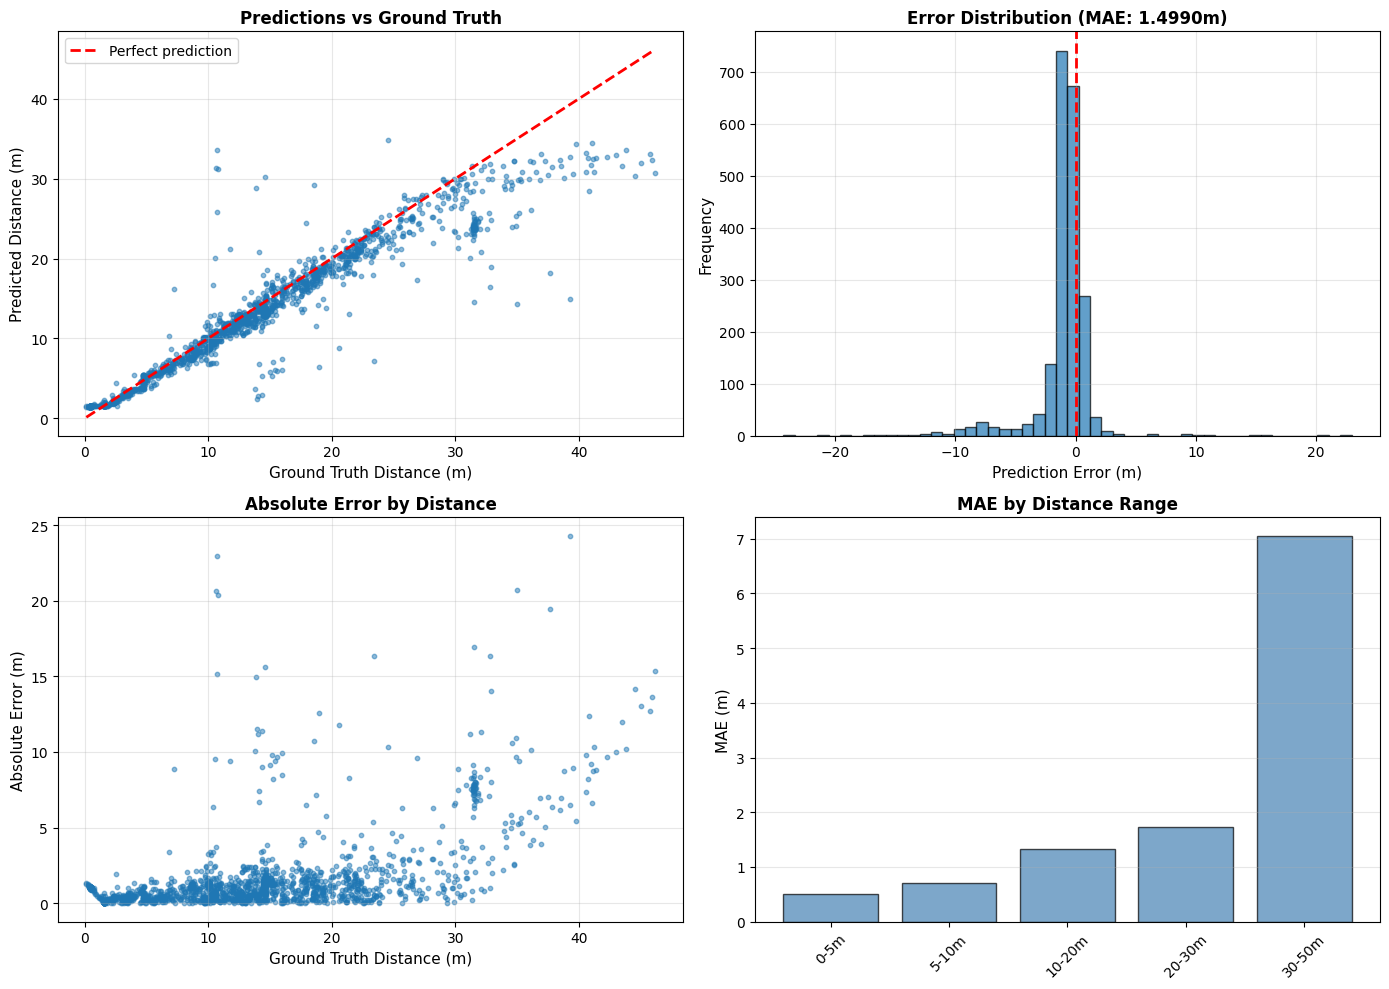

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predictions vs Targets
ax = axes[0, 0]
ax.scatter(test_targets, test_predictions, alpha=0.5, s=10)
ax.plot([test_targets.min(), test_targets.max()], 
        [test_targets.min(), test_targets.max()], 
        'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Ground Truth Distance (m)', fontsize=11)
ax.set_ylabel('Predicted Distance (m)', fontsize=11)
ax.set_title('Predictions vs Ground Truth', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Error distribution
ax = axes[0, 1]
errors = test_predictions - test_targets
ax.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Prediction Error (m)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Error Distribution (MAE: {mae:.4f}m)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Error by distance
ax = axes[1, 0]
ax.scatter(test_targets, np.abs(errors), alpha=0.5, s=10)
ax.set_xlabel('Ground Truth Distance (m)', fontsize=11)
ax.set_ylabel('Absolute Error (m)', fontsize=11)
ax.set_title('Absolute Error by Distance', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Distance-stratified MAE
ax = axes[1, 1]
range_labels = [f'{min_dist}-{max_dist}m' for min_dist, max_dist in distance_ranges]
range_maes = []

for min_dist, max_dist in distance_ranges:
    mask = (test_targets >= min_dist) & (test_targets < max_dist)
    if mask.sum() > 0:
        range_mae = mean_absolute_error(test_targets[mask], test_predictions[mask])
        range_maes.append(range_mae)
    else:
        range_maes.append(0)

ax.bar(range_labels, range_maes, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_ylabel('MAE (m)', fontsize=11)
ax.set_title('MAE by Distance Range', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./test_results.png', dpi=150, bbox_inches='tight')
print("\n✅ Visualization saved: test_results.png")
plt.show()

In [20]:
import pandas as pd

results_df = pd.DataFrame({
    'ground_truth': test_targets,
    'prediction': test_predictions,
    'error': test_predictions - test_targets,
    'abs_error': np.abs(test_predictions - test_targets),
    'relative_error_pct': (np.abs(test_predictions - test_targets) / (test_targets + 1e-6)) * 100
})

results_df.to_csv('./test_predictions.csv', index=False)
print("✅ Results saved: test_predictions.csv")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Total test samples: {len(test_targets)}")
print(f"Overall MAE: {mae:.4f}m")
print(f"Overall R²: {r2:.4f}")
print(f"Files saved:")
print(f"  - test_results.png")
print(f"  - test_predictions.csv")

✅ Results saved: test_predictions.csv

SUMMARY
Total test samples: 2068
Overall MAE: 1.4990m
Overall R²: 0.8906
Files saved:
  - test_results.png
  - test_predictions.csv
